
# **Responsible AI - Audit Code**

## **Team 1**


## **Instructions and Preliminaries**

This notebook contains the code that we used in order to obtain the 'technical findings' mentioned in the full audit report.

Before getting started, please note the following:

1. The notebook should be run on Google Colab. You can download it from the [GitHub page](https://github.com/cohen-ariel/RAI-audit) for the project, and then upload it to Colab.

2. In order to fully run the notebook, you will need to have a GPU on your machine, and the overall run might take up to 20 hours (explained in detail later in the notebook). If you would like to load the already-prepared result dictionaries, please upload the files ```results_success.pkl``` and ```results_MIR.pkl``` to Colab, specifically the general ```/content``` path (not in any specific folder). The files can be found in the following [link](https://drive.google.com/drive/folders/1IB_NUZN7YIDxubrHnTgXRGbUzRGC3BRu?usp=sharing). Then, keep following the instructions later in the notebook (you will have to run the code cell by cell, and possibly skip some cells).

3. Please upload the full data to the general ```/content``` path. The full data is composed of two .zip files: ```target_dataset.zip``` and ```passports_dataset.zip```. The two datasets can be found in the following [link](https://drive.google.com/drive/folders/1IB_NUZN7YIDxubrHnTgXRGbUzRGC3BRu?usp=sharing).

If you choose to run the entire notebook, you should run the cell below. The import statement can only be performed on a machine with a GPU.

Otherwise, if you want to load the already-prepared result dictionaries, you can skip the cell below.

In [1]:
!pip install -qqq face_recognition
import face_recognition as fr

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.1/100.1 MB 8.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In any case, run the imports below:

In [4]:
import fnmatch
import os
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
import glob
import zipfile
import random
import pickle
import numpy as np
from scipy.stats import bootstrap

%matplotlib inline

## **Loading the Data**

First, let us unzip and load the datasets into the ```data``` directory:

In [5]:
# create folder for data
os.mkdir("data")

# unzip datasets
with zipfile.ZipFile("target_dataset.zip", 'r') as zip_ref:
  zip_ref.extractall("data")

with zipfile.ZipFile("passports_dataset.zip", 'r') as zip_ref:
  zip_ref.extractall("data")

In [6]:
# define paths to the datasets
path_to_data = "/content/data"

path_to_target_dataset = f"{path_to_data}/target_dataset"  # contains both perfect and protest datasets
path_to_passports_dataset = f"{path_to_data}/passports_dataset"

# represent the datasets as lists of image paths
all_perfect_images = sorted(glob.glob(f"{path_to_target_dataset}/*_perfect_*.jpg"))
all_protest_images = sorted(glob.glob(f"{path_to_target_dataset}/*_protest_*.jpg"))
all_passports = sorted(glob.glob(f"{path_to_passports_dataset}/*.jpg"))

Now, let us display a sample of images from each dataset:



1. **'Perfect Dataset'**: contains images of civilians (celebrities) in optimal conditions. The "Bird's Eye" model was trained on images such as these.


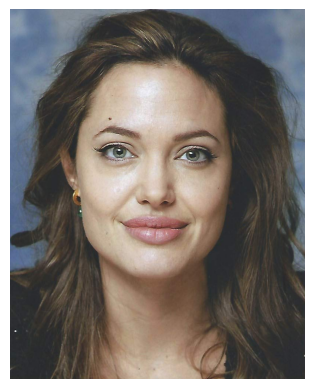

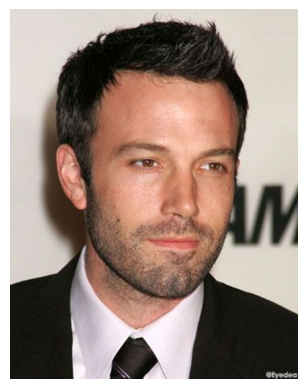

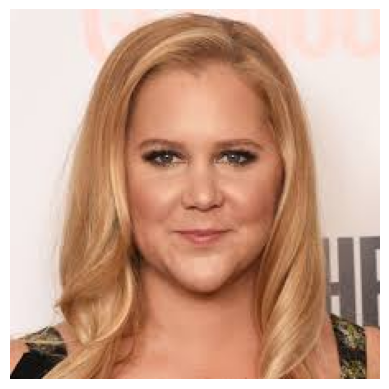

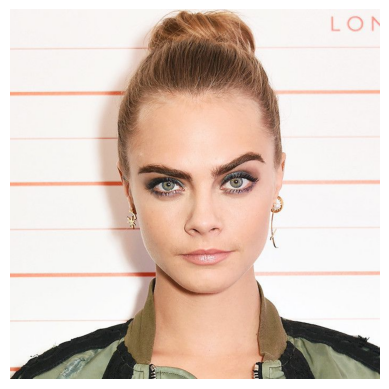

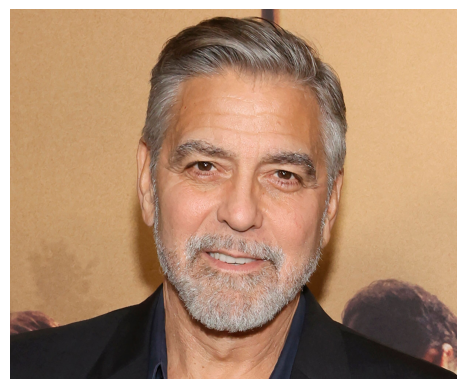

In [7]:
sampled_perfect_images = random.sample(all_perfect_images, 5)
for img_path in sampled_perfect_images:
  img = mpimg.imread(img_path)

  plt.imshow(img)
  plt.axis('off')
  plt.show()

2. **'Protest Dataset'**: contains images of the same civilians from the perfect dataset, but in more rough conditions for a photo, specifically in a protest.


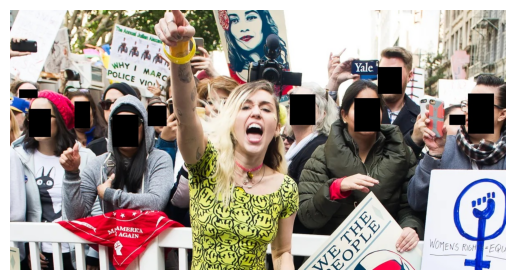

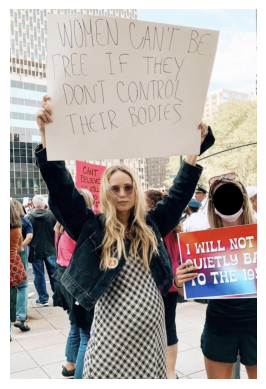

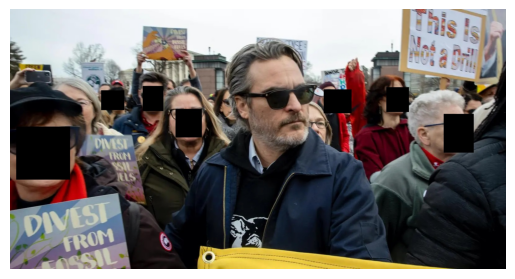

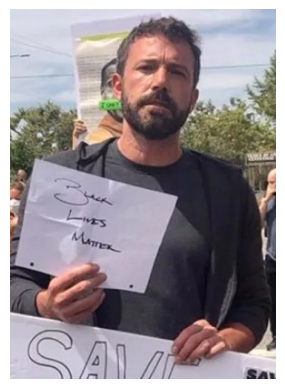

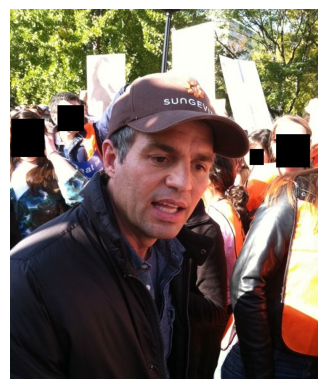

In [8]:
sampled_protest_images = random.sample(all_protest_images, 5)
for img_path in sampled_protest_images:
  img = mpimg.imread(img_path)

  plt.imshow(img)
  plt.axis('off')
  plt.show()

3. **'Passport Dataset'**: contains images of civilians' passports, which represent the police database. This dataset contains both celebrities and non-celebrities.

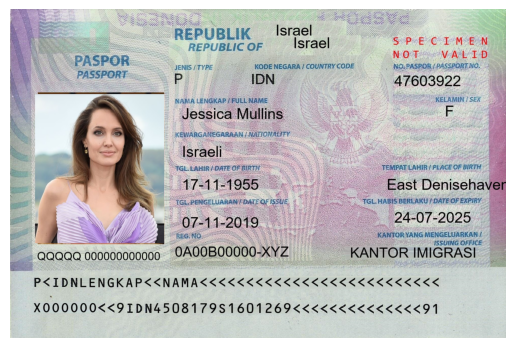

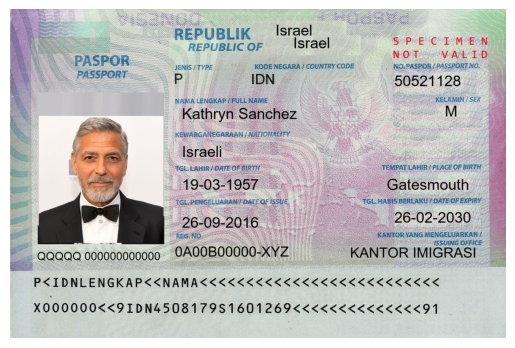

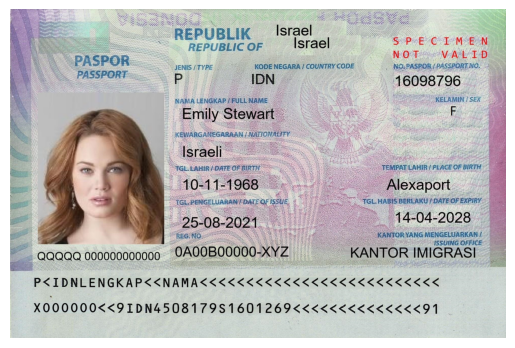

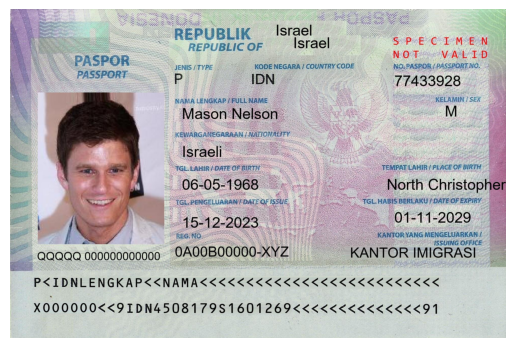

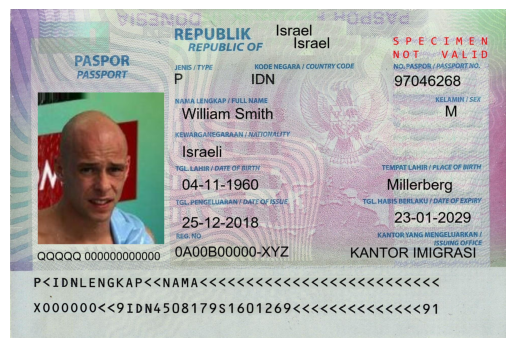

In [9]:
sampled_passports = random.sample(all_passports, 5)
for img_path in sampled_passports:
  img = mpimg.imread(img_path)

  plt.imshow(img)
  plt.axis('off')
  plt.show()

Define the following functions:

In [10]:
results_success_dict = {}
results_MIR_dict = {}

In [11]:
def extract_person_name(img_name):
  """
  Gets an image name and returns the name of the person.
  For example, the function gets: /content/data/target_dataset/mark_ruffalo_protest_1.jpg
  and returns: mark_ruffalo
  """
  person_name = img_name.split("/")[-1]
  person_name = person_name.split("_")[:2]
  if person_name[1] == "protest" or person_name[1] == "perfect":
    person_name.pop()

  person_name = "_".join(person_name)

  return person_name


def model(img1_name, img2_name, model_tolerance=0.65):
  """
  The face matching model
  """
  img1 = fr.load_image_file(img1_name)
  img2 = fr.load_image_file(img2_name)
  try:
    faceLoc = fr.face_locations(img2)    #locate where face is in picture
    encodes = fr.face_encodings(img2, faceLoc)  #apply face encoding
    encode = fr.face_encodings(img1)[0]    #apply encoding to test image
    matches = fr.compare_faces(encodes, encode, tolerance = model_tolerance) #match the two images and check same person or not (can check for multiple faces in the picture)
  except Exception as e:
    return []
  return matches


def get_face_identifications(img_name, passports):
  name_list = []
  for p in passports:
    result = model(img_name, p)
    if True in result:
      extracted_name = p.split("/")[-1]
      name_list.append(extracted_name.split(".")[0])

  return name_list


def update_dicts_with_metrics(images, passports):
  """
  1. Gets two datasets:
    - images (in our case, perfect/protest)
    - passports

  2. 'Crosses' the two datasets, looking for matches

  3. Updates two dictionaries with the success and MIR results for each image.
     That is, for each image in 'images' we receive several matches from 'passports',
     and for each such image we update the dictionaries; one dictionary contains
     the success results, and the other contains the MIR results.
  """
  MI_num = 0  # number of misidentifications
  identification_sum = 0  # sum of identifications
  success_sum = 0  # sum of "successful" identifications

  for img_name in images:
    img_name_no_path = img_name.split("/")[-1].split(".")[0]

    true_person_name = extract_person_name(img_name)
    pred_person_names = get_face_identifications(img_name, passports)

    identification_sum += len(pred_person_names)

    if len(pred_person_names) == 0:
      img_MIR = 0.0
    else:
      img_MIR = 1.0  # might be changed later

    if true_person_name in pred_person_names:
      img_MIR = (len(pred_person_names) - 1) / len(pred_person_names)

      success_sum += 1
      pred_person_names.remove(true_person_name)
      results_success_dict[img_name_no_path] = 1

    else:
      results_success_dict[img_name_no_path] = 0

    MI_num += len(pred_person_names)  # number of wrongly identified people for the current image
    results_MIR_dict[img_name_no_path] = img_MIR


def evaluation_on_datasets(metric):
  """
  Gets a metric (SR/MIR/police metric), calculates it for the perfect and protest datasets,
  and prints the results.
  """
  if metric == "SR":
    results_dict = results_success_dict

  if metric == "MIR":
    results_dict = results_MIR_dict

  if metric == "police metric":
    results_dict = {}
    for img_name, value in results_success_dict.items():
      if value == 1:
        results_dict[img_name] = 1

  perfect_keys = [key for key in results_dict.keys() if 'perfect' in key]
  protest_keys = [key for key in results_dict.keys() if 'protest' in key]

  perfect_values = [results_dict[key] for key in perfect_keys]
  protest_values = [results_dict[key] for key in protest_keys]

  # calculate and print success rates
  perfect_metric = sum(perfect_values) / len(perfect_keys)
  protest_metric = sum(protest_values) / len(protest_keys)

  print(f"PERFECT Dataset {metric}: {perfect_metric:.3f}")
  print(f"PROTEST Dataset {metric}: {protest_metric:.3f}")


Now, let us find the metrics "Success Rate" (SR) and "Misidentification Rate" (MIR) for both the Perfect dataset and the Protest dataset.

We will first update the result dictionaries, and calculate the metrics based on them.

**Note:** Running the cell below (updating the dictionaries) takes a significant amount of time (up to 20 hours with GPU). Thus, we attach the saved result dictionaries, ```results_success.pkl``` and ```results_MIR.pkl```, in the GitHub page for this project. To load them without having to run anything heavy, skip to the next cell.

In [ ]:
# evaluate the model on the perfect and protest datasets
update_dicts_with_metrics(all_perfect_images, all_passports)  # update dicts with perfect dataset results
update_dicts_with_metrics(all_protest_images, all_passports)  # update dicts with protest dataset results

# save success and MIR results to .pkl files
pickle_path = "/content/results_success.pkl"
with open(pickle_path, 'wb') as f:
  pickle.dump(results_success_dict, f)

pickle_path = "/content/results_MIR.pkl"
with open(pickle_path, 'wb') as f:
  pickle.dump(results_MIR_dict, f)

Skip **to** this cell to load the already-prepared result dictionaries:

In [12]:
# load saved success and MIR results
with open("/content/results_success.pkl", 'rb') as f:
    results_success_dict = pickle.load(f)

with open("/content/results_MIR.pkl", 'rb') as f:
    results_MIR_dict = pickle.load(f)

Display the metric results:

In [13]:
evaluation_on_datasets(metric="SR")
print()
evaluation_on_datasets(metric="MIR")

PERFECT Dataset SR: 1.000
PROTEST Dataset SR: 0.778

PERFECT Dataset MIR: 0.245
PROTEST Dataset MIR: 0.328


Now, let us display bootstrapped confidence intervals for the metrics above, with CL=0.95:

In [14]:
# statistic functoin for bootstrap (in this case, the mean)
def calculate_mean(data, axis):
    return np.mean(data, axis=axis)

# number of bootstrap resamples
n_resamples = 500

Confidence intervals for the SR metric:

Data is degenerate; confidence intervals cannot be computed for Perfect.
Confidence Interval (95% confidence) of Protest: ConfidenceInterval(low=0.6430793041824181, high=0.8703703703703703)


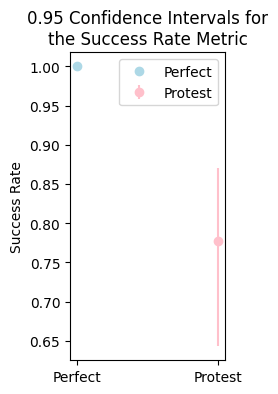

In [15]:
# extract keys and values for perfect and protest datasets
perfect_keys = [key for key in results_success_dict.keys() if 'perfect' in key]
protest_keys = [key for key in results_success_dict.keys() if 'protest' in key]

perfect_values = [results_success_dict[key] for key in perfect_keys]
protest_values = [results_success_dict[key] for key in protest_keys]

# storing data for plotting
ci_data = []
means = []

for values, category in [(perfect_values, 'Perfect'), (protest_values, 'Protest')]:
    mean_value = np.mean(values)
    means.append((category, mean_value))
    # perform the bootstrap resampling only if there is variance in the data
    if np.var(values) > 0:
        res = bootstrap((np.array(values),), statistic=calculate_mean, n_resamples=n_resamples, vectorized=True)
        confidence_interval = res.confidence_interval
        ci_data.append((category, mean_value, confidence_interval.low, confidence_interval.high))
        print(f"Confidence Interval (95% confidence) of {category}:", confidence_interval)
    else:
        print(f"Data is degenerate; confidence intervals cannot be computed for {category}.")
        ci_data.append((category, mean_value, None, None)) # handling degenerate cases


# plotting CIs
fig, ax = plt.subplots(figsize=(2, 4))
colors = ['lightblue', 'pink']
for i, data in enumerate(ci_data):
    category, mean, low, high = data
    if low is not None and high is not None:
        ax.errorbar(i, mean, yerr=[[mean - low], [high - mean]], fmt='o', color=colors[i % len(colors)], label=f'{category}')
    else:
        ax.plot(i, mean, 'o', color=colors[i % len(colors)], label=f'{category}')

ax.set_title('0.95 Confidence Intervals for\nthe Success Rate Metric')
ax.set_ylabel('Success Rate')
ax.set_xticks(range(len(ci_data)))
ax.set_xticklabels([data[0] for data in ci_data])
plt.legend()
plt.show()

Confidence intervals for the MIR metric:

Confidence Interval (95% confidence) of Perfect: ConfidenceInterval(low=0.17901234567901234, high=0.3441358024691358)
Confidence Interval (95% confidence) of Protest: ConfidenceInterval(low=0.2394924040795908, high=0.4250444634952994)


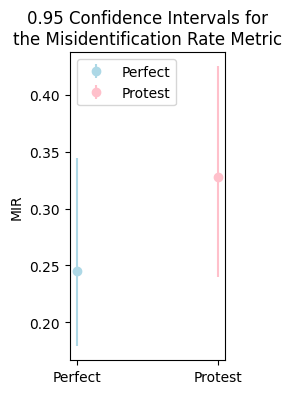

In [16]:
# extract keys and values for perfect and protest datasets
perfect_keys = [key for key in results_MIR_dict.keys() if 'perfect' in key]
protest_keys = [key for key in results_MIR_dict.keys() if 'protest' in key]

perfect_values = [results_MIR_dict[key] for key in perfect_keys]
protest_values = [results_MIR_dict[key] for key in protest_keys]

# storing data for plotting
ci_data = []
means = []

for values, category in [(perfect_values, 'Perfect'), (protest_values, 'Protest')]:
    mean_value = np.mean(values)
    means.append((category, mean_value))
    # perform the bootstrap resampling only if there is variance in the data
    if np.var(values) > 0:
        res = bootstrap((np.array(values),), statistic=calculate_mean, n_resamples=n_resamples, vectorized=True)
        confidence_interval = res.confidence_interval
        ci_data.append((category, mean_value, confidence_interval.low, confidence_interval.high))
        print(f"Confidence Interval (95% confidence) of {category}:", confidence_interval)
    else:
        print(f"Data is degenerate; confidence intervals cannot be computed for {category}.")
        ci_data.append((category, mean_value, None, None)) # handling degenerate cases


# plotting CIs
fig, ax = plt.subplots(figsize=(2, 4))
colors = ['lightblue', 'pink']
for i, data in enumerate(ci_data):
    category, mean, low, high = data
    if low is not None and high is not None:
        ax.errorbar(i, mean, yerr=[[mean - low], [high - mean]], fmt='o', color=colors[i % len(colors)], label=f'{category}')
    else:
        ax.plot(i, mean, 'o', color=colors[i % len(colors)], label=f'{category}')

ax.set_title('0.95 Confidence Intervals for\nthe Misidentification Rate Metric')
ax.set_ylabel('MIR')
ax.set_xticks(range(len(ci_data)))
ax.set_xticklabels([data[0] for data in ci_data])
plt.legend(loc="upper left")
plt.show()

Finally, let us calculate the police metric ("Accuracy") that we assume might've been used by the police:

In [17]:
evaluation_on_datasets(metric="police metric")

PERFECT Dataset police metric: 1.000
PROTEST Dataset police metric: 1.000
